# Sound Field Synthesis

[return to main page](index.ipynb)

## Preparations

In [1]:
from matplotlib import pyplot as plt
import sfs  # tested for version 0.5.0
import numpy as np
import scipy.special

## Basic Principle

<img src="data/sfs/sfs_discrete.png" width="400"/>

The goal is to synthesize the sound field of a virtual source $S(\mathbf{x},\omega)$ within the listening area (yellow) with an ensemble of individually driven secondary sources (loudspeakers) surrounding the area. The reproduced sound field given as

$$
P(\mathbf{x},\omega) = \sum_{l=1}^{L} D(\mathbf{x}_l,\omega) \; G(\mathbf{x}|\mathbf{x}_l,\omega)
$$

which states the superposition of the sound fields $G(\mathbf{x}|\mathbf{x}_l,\omega)$ emitted by each individual secondary sources. Here, each loudspeaker emits its respective **driving signal** $D(\mathbf{x}_l,\omega)$. 

<img src="data/sfs/sfs_continuous.png" width="400"/>

For the continuous case, i.e. the spacing between the secondary sources is zero, the sum migrates to an integral

$$
P(\mathbf{x},\omega)=\oint_{\partial V} D(\mathbf{x}_0,\omega) \; G(\mathbf{x} | \mathbf{x}_0,\omega) \; \mathrm{d}A(\mathbf{x}_0)
$$

which is the so-called **Single Layer Potential**. It needs to be solved for $D(\mathbf{x}_0,\omega)$ under the condition $P(\mathbf{x},\omega) = S(\mathbf{x},\omega)$. Most approaches assume that the all secondary source emit the same sound field $G(\mathbf{x}|\mathbf{x}_0,\omega) = G(\mathbf{x} - \mathbf{x}_0,\omega)$ and free-field propagation. The loudspeakers sound field is modelled as a point source by the free-field Green's function $G_0$

$$
P(\mathbf{x},\omega)=\oint_{\partial V} D(\mathbf{x}_0,\omega) \; G_0(\mathbf{x} - \mathbf{x}_0,\omega) \; \mathrm{d}A(\mathbf{x}_0)
$$

Under the assumptions made in the prior section, the *Single Layer Potential* describes a convolution along surface $\partial V$. In the following, we get to know some approaches for solving it.

## Explicit Solution

### Analogies to the Time-Domain

Let's make a small step back and see how we conveniently solve a similar problem in a different domain, namely the time-domain: We assume, that we have measured the output signal $y(t)$ of a LTI-System with unknown impulse response $h(t)$ given the input signal $x(t)$. The three entities are connected over the convolution integral

$$
y(t) = \int_{-\infty}^{\infty} x(\tau) h(t-\tau) \mathrm d \tau\,.
$$

In order to determine $h(t)$ we have to solve the integral equation with respect to $h(t)$. We can express the signals as the inverse Fourier transform using its respective Fourier spectrum, see

$$
y(t) = \frac{1}{2 \pi} \int_{-\infty}^{\infty} Y(j\omega) e^{+j\omega t} \mathrm d \omega \\
x(\tau) = \frac{1}{2 \pi} \int_{-\infty}^{\infty} X(j\omega) e^{+j\omega \tau} \mathrm d \omega
\\
h(t-\tau) = \frac{1}{2 \pi} \int_{-\infty}^{\infty} H(j\omega) e^{+j\omega t} e^{-j\omega \tau} \mathrm d \omega
$$

We expanded each signal as a superposition of weigthed basis functions $\Psi(\omega,t)$. The weights are the Fourier Spectra, e.g. $Y(j\omega)$, and the basis functions $\Psi(\omega,t)$ are the expontentials, e.g. $e^{+j\omega t}$.
A very important property of this basis functions $e^{+j\omega t}$ is its orthogonality

$$
\int_{-\infty}^{\infty} e^{+j\omega_1 t} e^{-j\omega_2 t} \mathrm d t = 
2\pi \delta(\omega_1 - \omega_2)
$$

with respect to the integral $\int_{-\infty}^{\infty} \mathrm d t$. We insert the expansion into the convolution integral:

$$
\frac{1}{2 \pi} \int_{-\infty}^{\infty} Y(j\omega) e^{+j\omega t} \mathrm d \omega = 
\color{red}{\int_{-\infty}^{\infty}}
    \Big[ 
    \frac{1}{2 \pi} \int_{-\infty}^{\infty} X(j\omega_1)\;\color{red}{e^{+j\omega_1 \tau}} \;\mathrm d \omega_1
    \frac{1}{2 \pi} \int_{-\infty}^{\infty} H(j\omega_2)\;e^{+j\omega_2 t}\;\color{red}{e^{-j\omega_2 \tau}} \;\mathrm d \omega_2
    \Big]
\color{red}{\mathrm d \tau}
$$

We can now solve the integral with respect to $\tau$ (red) using the orthogonality of the exponentials. This results in

$$
\frac{1}{2 \pi} \int_{-\infty}^{\infty} Y(j\omega) e^{+j\omega t} \mathrm d \omega = 
    \frac{1}{2 \pi} 
    \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} X(j\omega_1) 
     H(j\omega_2) e^{+j\omega_2 t} \delta(\omega_1 - \omega_2) \, \mathrm d \omega_1 \mathrm d \omega_2
$$

The integral with respect to $\omega_1$ can be solved by the identity for the dirac delta distribution

$$
\int_{-\infty}^{\infty} F(\omega_1) \delta(\omega_1 - \omega_2) \, \mathrm d \omega_1 =  F(\omega_2)
$$

The result reads

$$
\frac{1}{2 \pi} \int_{-\infty}^{\infty} \color{blue}{Y(j\omega)} e^{+j\omega t} \mathrm d \omega = 
\frac{1}{2 \pi}  \int_{-\infty}^{\infty} \color{blue}{X(j\omega_2) H(j\omega_2)} e^{+j\omega_2 t} \mathrm d \omega_2 \,.
$$

Besides the integration variables, the integrals are the same, so the terms within the integrals are equal. We can hence infer, that a convolution of two signals in the time-domain results in a multiplication of the respective spectra in the frequency-domain. Hence, we can get the spectrum of the impulse response via

$$
H(j\omega) = \frac{Y(j\omega)}{X(j\omega)}
$$

and the impulse response via the inverse Fourier transform

$$
h(t) = \frac{1}{2 \pi} \int_{-\infty}^{\infty} \frac{Y(j\omega)}{X(j\omega)} e^{+j\omega t}
$$

What have we learned? First of all, we have to know the basis function, with are orthogonal 
with respect to the integral defined by the convolution. We can solve the convolution integral with respect to $h(t)$ expanding the entities into this basic function, and divide the resulting spectra of $x(t)$ and $y(t)$. $h(t)$ is then given by the inverse transform.

### Solving the Single Layer Potential

Let's get back to the original Problem:

$$
P(\mathbf{x},\omega)=\oint_{\partial V} D(\mathbf{x}_0,\omega) \; G_0(\mathbf{x} - \mathbf{x}_0,\omega) \; \mathrm{d}A(\mathbf{x}_0)
$$

Obviously the convolution is now defined with regard to space along a 2-dimensional surface. As this surface is closed, the functions defined on it have to be periodic: If one moves around the surface back to the original starting point, the functions have to yield the same values. We know from the time-domain that periodic signals are expressed into basis functions using the Fourier series. Contrary to the Fourier Transform, the Fourier series is only defined for frequencies being an integer multiple $n$ of the fundamental frequency $f_0 = \frac{1}{T}$, where $T$ is the period of the signal. The spatial spectra of function on the surface are hence discrete and the frequency variable is an integer, e.g. $n$.

Assuming that we know the basis functions $\Psi_n(\mathbf{x}_0)$, which are orthogonal on the surface, i.e.

$$
\oint_{\partial V} \Psi_{n_2}(\mathbf{x}_0) \Psi^*_{n_1}(\mathbf{x}_0) \; \mathrm{d}A(\mathbf{x}_0) = a_{n_1} \delta[n_1 - n_2]\,,
$$

we can expand the involved function over the basis functions

$$
P(\mathbf{x},\omega)= \sum_{n=0}^{\infty} \tilde P_n(\omega) \Psi_n(\mathbf{x})\\
D(\mathbf{x},\omega)= \sum_{n=0}^{\infty} \tilde D_n(\omega) \Psi_n(\mathbf{x})\\
G(\mathbf{x},\omega)= \sum_{n=0}^{\infty} \tilde G_n(\omega) \Psi_n(\mathbf{x})
$$

with $P_n$, $D_n$, and $G_n$ being the respective spatial spectra. The spatial spectrum of the driving is computed analogue to the time-domain example via
$$
\tilde D_n(\omega) = \frac{\tilde P_n(\omega)}{\tilde G_n(\omega)}\,.
$$

The final driving signal is given as
$$
D(\mathbf{x},\omega) = \sum_{n=0}^{\infty} \frac{\tilde P_n(\omega)}{a_n \tilde G_n(\omega)} \Psi_n(\mathbf{x})\,.
$$

In general, finding the basis function for a specific surface shape is challenging, if not impossible. The explicit solution of the Single Layer Potential is hence only feasible for simple geometries such as spheres, circles, or planes.

### Circular Geometries

For a circular distribution of secondary sources, the single layer potential reads

$$
P(\mathbf{x},\omega)= \int_0^{2\pi} D(\phi_0,\omega) \; G_0(\mathbf{x} - \mathbf{x}_0,\omega) \;R\;\mathrm d \phi_0
$$

For this convolution integral, the basic functions are given as $\Psi_n(\mathbf{x}) = e^{+j\phi n}$ and $a_n = 2\pi$ and $n \in (-\infty; \infty)$. As this is two-dimensional scenario, we also need the two-dimensional Green's function which is a [line source](physics_of_sound_I.ipynb#Line-Source)

$$
G_0(\mathbf{x} - \mathbf{x}_0,\omega) = -\frac{j}{4} H_0\left( \frac{\omega}{c} \sqrt{(x-x_0)^2 + (y-y_0)^2}\right)
$$

It's angular spectrum is given as 

$$
\tilde G_n(\omega) = -\frac{j}{4}\;H_n\left(\frac{\omega}{c} R\right)\;J_n\left(\frac{\omega}{c} r\right)
$$

We use the [cylindrical Hankel functions of 2nd kind](https://dlmf.nist.gov/10.2#ii) of order $n$, especially of order $0$ for $H_0$.

For the desired sound field we choose a plane wave

$$
P_{pw}(\mathbf x, \omega) = \mathrm{exp}\left(-j\frac{\omega}{c} \mathbf n_{\mathrm {pw}} \cdot \mathbf x \right)
$$

with propagation direction $\mathbf n_{\mathrm {pw}} = [\cos \phi_{pw}, \sin \phi_{pw}, 0]^T$ and the angular spectrum

$$
P_n(\omega) = j^{-n} e^{-jn\phi_{pw}}\;J_n\left(\frac{\omega}{c} r\right)
$$

The resulting spatial spectrum of the driving signal reads

$$
D_n(\omega) = \frac{1}{2\pi R} \frac{j^{-n} e^{-jn\phi_{pw}}}{-\frac{j}{4}\;H_n\left(\frac{\omega}{c} R\right)}
= \frac{2}{\pi R}\;\frac{j^{-n+1} e^{-jn\phi_{pw}}}{H_n\left(\frac{\omega}{c} R\right)}
$$

In practice, we have to truncate the summation:

$$
D(\mathbf{x},\omega) \approx \sum_{n=-M}^{M} D_n(\omega)\,e^{+j\phi n}.
$$

Let's start to code a little bit to understand the concept by an example.

In [2]:
def nfchoa_2d_plane(omega, x0, r0, n=[0, 1, 0], max_order=None, c=None):
    """Plane wave by two-dimensional NFC-HOA.

    from the sound field synthesis toolbox with minor modifications

    ::

                               __
                       2i     \        i^-m
        D(phi0,w) = - -----   /__   ----------  e^(i m (phi0-phi_pw))
                      pi r0 m=-N..N  (2)
                                    Hm  (w/c r0)

    """
    x0 = sfs.util.asarray_of_rows(x0)
    k = sfs.util.wavenumber(omega, c)
    alpha, beta, r = sfs.util.cart2sph(n[0], n[1], n[2])
    alpha0, beta0, tmp = sfs.util.cart2sph(x0[:, 0], x0[:, 1], x0[:, 2])
    # determine max order of circular harmonics
    M = len(x0) // 2 if max_order is None else max_order
    # compute driving function
    d = 0
    for m in np.arange(-M, M):
        d = d + 1j**(-m) / scipy.special.hankel2(m, k * r0) * \
            np.exp(1j * m * (alpha0 - alpha))

    # 2020-11-11: added np.exp(-1j*np.pi/4), to be double checked!
    return 2j / (np.pi*r0) * d * np.exp(-1j*np.pi/4)


def nfchoa_2d_plane_modal(omega, m, r0, n=[0, 1, 0], max_order=None, c=None):
    """get modal coefficients of above used Plane wave by two-dimensional NFC-HOA.

    from the sound field synthesis toolbox with minor modifications

    ::

                               __
                       2i     \        i^-m
        D(phi0,w) = - -----   /__   ----------  e^(i m (phi0-phi_pw))
                      pi r0 m=-N..N  (2)
                                    Hm  (w/c r0)

    """
    k = sfs.util.wavenumber(omega, c)
    alpha, beta, r = sfs.util.cart2sph(n[0], n[1], n[2])
    # compute driving function
    dm = np.zeros(np.shape(m), dtype='complex')
    for idx, mu in enumerate(m):
        dm[idx] = 1j**(-mu) /\
            scipy.special.hankel2(mu, k * r0) * np.exp(1j * mu * (- alpha))

    # 2020-11-11: added np.exp(-1j*np.pi/4), to be double checked!
    return 2j / (np.pi*r0) * dm * np.exp(-1j*np.pi/4)


def plot_circ_spectrum(Dm, m, omega, omega_ref):
    """plot the modal spectrum over mode index and frequency."""
    # Dm = Dm / np.max(np.abs(Dm[:]))

    plt.pcolormesh(m, omega/(2*np.pi), 20*np.log10(np.abs(Dm)), cmap='viridis')
    plt.plot([-100, +100], [omega_ref/2/np.pi, omega_ref/2/np.pi], 'C7')
    plt.ylim([np.min(omega/(2*np.pi)), np.max(omega/(2*np.pi))])
    plt.xlim([np.min(m), np.max(m)])
    plt.colorbar()
    plt.clim([-60, 20])

    plt.xlabel(r'mode index $m$')
    plt.ylabel('$f$ / Hz')
    plt.title(r'color: $20\,\log_{10}|D_m|$ / dB')

In [3]:
grid = sfs.util.xyz_grid(
    [-2, 2], [-2, 2], 0, spacing=0.01)  # grid for plotting
R = 2  # radius of circular array (m)

In [4]:
npw = 1, 0, 0  # progagation direction of plane wave
f = 343*3  # time-frequency (Hz), then wave length is 1/3 m
omega = 2 * np.pi * f  # angular frequency (rad/s)
M = 100  # modal order

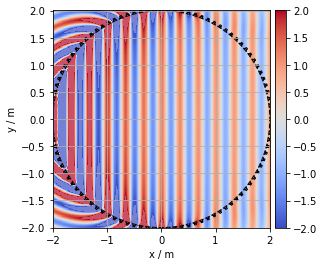

In [5]:
N = 100  # number of monopoles, enough to simulate a quasi-continuous array
array = sfs.array.circular(N, R)  # circular array

# above defined driving function
d = nfchoa_2d_plane(omega, array.x, R, n=npw, max_order=M)

p = sfs.fd.synthesize(d, np.ones(N), array, sfs.fd.secondary_source_point(
    omega, sfs.default.c), grid=grid)

sfs.plot2d.amplitude(p, grid)
sfs.plot2d.loudspeakers(array.x, array.n, array.a)
plt.grid(True)

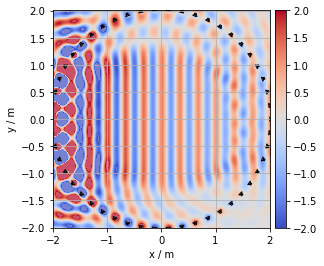

In [6]:
N = 50
array = sfs.array.circular(N, R)  # circular array

# use above defined driving function
# check how the spatial aliasing region and the intended planar wave front
# changes if we set up different
# max_order = 1  # what actually happens here?!
# max_order = N//2-1  # this is a practical used case
# max_order = M  # compare this with WFS!
d = nfchoa_2d_plane(omega, array.x, R, n=npw, max_order=N//2-1)

p = sfs.fd.synthesize(d, np.ones(N), array, sfs.fd.secondary_source_point(
    omega, sfs.default.c), grid=grid)

sfs.plot2d.amplitude(p, grid)
sfs.plot2d.loudspeakers(array.x, array.n, array.a)
plt.grid(True)

## Modal Spectrum

### No Spatial Aliasing

due to Quasi-Continuous Array


In [7]:
omega = 2 * np.pi * np.linspace(300, 3000, 100)  # angular frequency (rad/s)
m = np.arange(-100, 101)  # modal variable

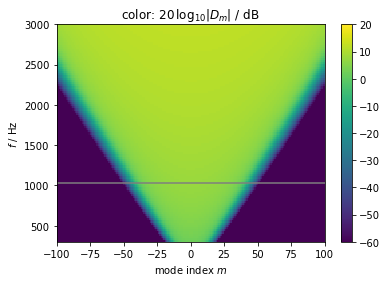

In [8]:
Dm = np.zeros((len(omega), len(m)), dtype='complex')
for idx, om in enumerate(omega):
    Dm[idx, :] = nfchoa_2d_plane_modal(om, m, R, n=npw)  # driving signals

plot_circ_spectrum(Dm, m, omega, 2*np.pi*f)

### Spatial Aliasing

due to Discrete Array

In the above example with `N=50` loudspeakers we might restrict the `max_order = N//2-1`, which is 24. Regarding the plot below, can you explain this choice? What do we support or rather avoid for certain regions in the plot?

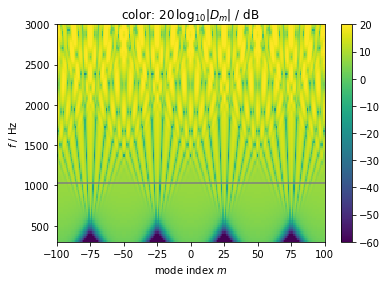

In [9]:
N = 50  # number of loudspeakers
mu = np.arange(-3, 4)  # spatial aliasing == spectral repetitions of the modes

Dm = np.zeros((len(omega), len(m)), dtype='complex')
for idx, om in enumerate(omega):
    for shift in N*mu:
        Dm[idx, :] = Dm[idx, :] + \
            nfchoa_2d_plane_modal(om, m-shift, R, n=npw)  # driving signal

plot_circ_spectrum(Dm, m, omega, 2*np.pi*f)

# Implicit Solution

Wave Field Synthesis (WFS)

- theory tutorial: https://git.iem.at/zotter/wfs-basics
- latest WFS findings with a very good WFS overview: https://last.hit.bme.hu/download/firtha/PhD_thesis/firtha_phd_thesis.pdf

WFS driving functions contain **infinite modal order** and are obtained under assumption that **far-field/high-frequency conditions** hold. WFS is a so called **implicit** solution of the sound field synthesis problem, because we do not explicitly solve the integral for the driving function, but rather think about what it should be implicitly to obtain a desired sound field.  

A comparison between explicit and implicit solution is found in this recent [paper](https://github.com/spatialaudio/sfs-with-local-wavenumber-vector-concept/blob/master/daga2019/Schultz_2019_HOA_vs_WFS_DAGA_Slides_1.00.pdf), in this [paper](https://www.int.uni-rostock.de/fileadmin/user_upload/publications/spors/2009/AES126_Ahrens_etal_timbral_coloration.pdf) and in this [book](https://link.springer.com/book/10.1007/978-3-642-25743-8)

The implicit solution therefore has no `modal_order` parameter (or is rather infinite number of modes) to calculate WFS driving functions. Thus, if we have not enough loudspeakers `N`, we have to accept spatial aliasing.

- Play around with different `N` and check where the spatial aliasing region and where (if any) a spatial aliasing free region occurs. Can you explain why this is the case.
- Also play around with the frequency `f` and link the finding to the spatial sampling theorem.

In [10]:
def plot(d, selection, secondary_source):
    p = sfs.fd.synthesize(d, selection, array, secondary_source, grid=grid)
    sfs.plot2d.amplitude(p, grid)
    sfs.plot2d.loudspeakers(array.x, array.n, selection * array.a, size=0.15)

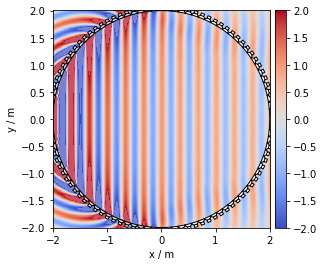

In [11]:
N = 100
array = sfs.array.circular(N, R)  # circular array
d, selection, secondary_source = sfs.fd.wfs.plane_25d(
    2*np.pi*f, array.x, array.n, npw)
plot(d, selection, secondary_source)

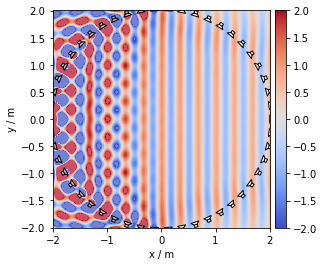

In [12]:
N = 50
array = sfs.array.circular(N, R)  # circular array
d, selection, secondary_source = sfs.fd.wfs.plane_25d(
    2*np.pi*f, array.x, array.n, npw)
plot(d, selection, secondary_source)

<p xmlns:dct="http://purl.org/dc/terms/">
  <a rel="license"
     href="http://creativecommons.org/publicdomain/zero/1.0/">
    <img src="http://i.creativecommons.org/p/zero/1.0/88x31.png" style="border-style: none;" alt="CC0" />
  </a>
  <br />
  To the extent possible under law,
  <span rel="dct:publisher" resource="[_:publisher]">the person who associated CC0</span>
  with this work has waived all copyright and related or neighboring
  rights to this work.
</p>